Training stopped at epoch 313 due to convergence.


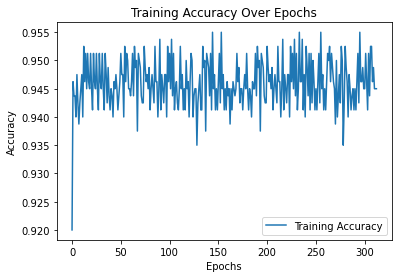

Accuracy: 0.99
Precision: 1.00
Recall: 0.98
F1 Score: 0.99


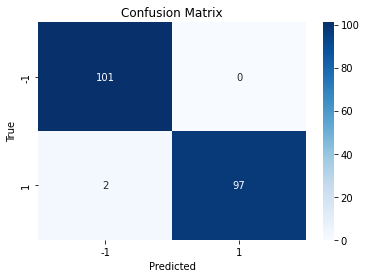

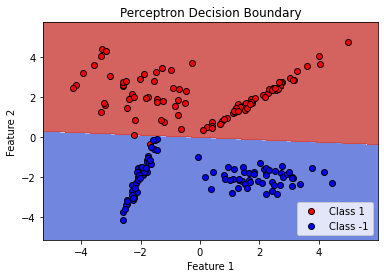

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Generate dataset
def generate_data(samples=1000, features=10, class_sep=2):
    X, y = make_classification(
        n_samples=samples,
        n_features=features,
        n_classes=2,
        class_sep=class_sep,
        n_redundant=0,
        random_state=42,
    )
    y = np.where(y == 0, -1, 1)  # Convert labels to -1 and 1
    return X, y

# Initialize Perceptron
class Perceptron:
    def __init__(self, lr=0.01, max_epochs=1000):
        self.lr = lr
        self.max_epochs = max_epochs
        self.weights = None
        self.bias = None

    def feedforward(self, X):
        """Compute the weighted sum and apply the sign activation."""
        linear_output = np.dot(X, self.weights) + self.bias
        return np.sign(linear_output)

    def train(self, X, y):
        """Train the perceptron using the Perceptron Learning Rule."""
        n_samples, n_features = X.shape
        self.weights = np.random.uniform(-0.5, 0.5, size=n_features)
        self.bias = np.random.uniform(-0.5, 0.5)

        accuracy_history = []
        for epoch in range(self.max_epochs):
            incorrect = 0
            for idx, x_i in enumerate(X):
                prediction = self.feedforward(x_i)
                if prediction != y[idx]:
                    update = self.lr * y[idx]
                    self.weights += update * x_i
                    self.bias += update
                    incorrect += 1

            # Calculate and store epoch accuracy
            epoch_accuracy = 1 - (incorrect / n_samples)
            accuracy_history.append(epoch_accuracy)

            # Early stopping condition (convergence)
            if epoch > 2 and accuracy_history[-1] == accuracy_history[-2] == accuracy_history[-3]:
                print(f"Training stopped at epoch {epoch + 1} due to convergence.")
                break

        return accuracy_history

    def predict(self, X):
        """Make predictions for the given input."""
        return self.feedforward(X)

# Visualize Decision Boundary
def plot_decision_boundary(X, y, perceptron):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    Z = perceptron.feedforward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap="coolwarm")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", edgecolor="k", label="Class 1")
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color="blue", edgecolor="k", label="Class -1")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Perceptron Decision Boundary")
    plt.legend()
    plt.show()

# Evaluate Model
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["-1", "1"], yticklabels=["-1", "1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Main
if __name__ == "__main__":
    # Generate data
    X, y = generate_data(samples=1000, features=2, class_sep=2)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the perceptron
    perceptron = Perceptron(lr=0.01, max_epochs=1000)
    accuracy_history = perceptron.train(X_train, y_train)

    # Plot training accuracy over epochs
    plt.plot(accuracy_history, label="Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Over Epochs")
    plt.legend()
    plt.show()

    # Test the model
    y_pred = perceptron.predict(X_test)
    evaluate_model(y_test, y_pred)

    # Visualize decision boundary
    plot_decision_boundary(X_test, y_test, perceptron)


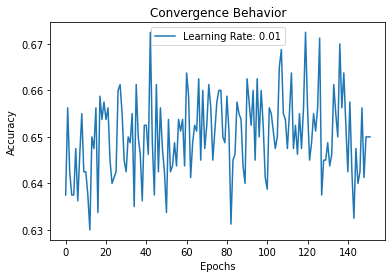

In [18]:
# Plot accuracy over epochs for a given learning rate
plt.plot(accuracy_history, label=f"Learning Rate: {perceptron.lr}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Convergence Behavior")
plt.legend()
plt.show()


Training stopped at epoch 152 due to convergence.


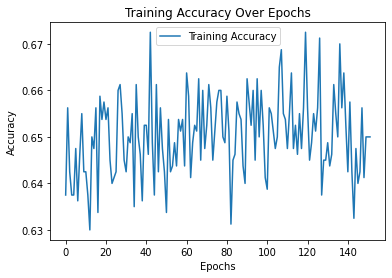

Test Accuracy: 0.55


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Generate dataset
def generate_data(samples=1000, features=2, class_sep=0.5):
    X, y = make_classification(
        n_samples=samples,
        n_features=features,
        n_classes=2,
        class_sep=class_sep,
        n_redundant=0,
        random_state=42,
    )
    y = np.where(y == 0, -1, 1)  # Convert labels to -1 and 1
    return X, y

# Kernelized Perceptron Class
class KernelPerceptron:
    def __init__(self, lr=0.01, max_epochs=1000, kernel='poly', degree=2, gamma=None):
        self.lr = lr
        self.max_epochs = max_epochs
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.alpha = None
        self.bias = 0

    def _kernel_matrix(self, X):
        """Compute the kernel matrix for all pairwise operations."""
        if self.kernel == 'poly':
            return (np.dot(X, X.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1 / X.shape[1]
            X_norm = np.sum(X ** 2, axis=1)
            return np.exp(-self.gamma * (X_norm[:, None] + X_norm[None, :] - 2 * np.dot(X, X.T)))
        else:
            return np.dot(X, X.T)

    def _kernel_matrix_predict(self, X_test, X_train):
        """Compute the kernel matrix for prediction (test vs. train)."""
        if self.kernel == 'poly':
            return (np.dot(X_test, X_train.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1 / X_train.shape[1]
            X_test_norm = np.sum(X_test ** 2, axis=1)
            X_train_norm = np.sum(X_train ** 2, axis=1)
            return np.exp(
                -self.gamma * (X_test_norm[:, None] + X_train_norm[None, :] - 2 * np.dot(X_test, X_train.T))
            )
        else:
            return np.dot(X_test, X_train.T)

    def train(self, X, y):
        """Train the perceptron using the Kernel Perceptron algorithm."""
        self.X_train = X  # Store training data
        self.y_train = y  # Store training labels

        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)
        self.bias = 0

        # Compute the kernel matrix
        kernel_matrix = self._kernel_matrix(X)
        accuracy_history = []

        for epoch in range(self.max_epochs):
            incorrect = 0
            for i in range(n_samples):
                prediction = np.sign(np.sum(self.alpha * y * kernel_matrix[i]) + self.bias)
                if prediction != y[i]:
                    self.alpha[i] += self.lr
                    self.bias += self.lr * y[i]
                    incorrect += 1

            epoch_accuracy = 1 - (incorrect / n_samples)
            accuracy_history.append(epoch_accuracy)

            # Early stopping if converged
            if epoch > 2 and accuracy_history[-1] == accuracy_history[-2] == accuracy_history[-3]:
                print(f"Training stopped at epoch {epoch + 1} due to convergence.")
                break

        return accuracy_history

    def predict(self, X_test):
        """Predict labels for given test data using the trained model."""
        kernel_matrix = self._kernel_matrix_predict(X_test, self.X_train)
        predictions = np.sign(np.dot(self.alpha * self.y_train, kernel_matrix.T) + self.bias)
        return predictions

# Main script
if __name__ == "__main__":
    # Generate non-linearly separable data
    X, y = generate_data(samples=1000, features=2, class_sep=0.5)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the kernelized perceptron (with polynomial kernel)
    perceptron = KernelPerceptron(lr=0.01, max_epochs=1000, kernel='poly', degree=2)
    accuracy_history = perceptron.train(X_train, y_train)

    # Plot training accuracy over epochs
    plt.plot(accuracy_history, label="Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Over Epochs")
    plt.legend()
    plt.show()

    # Test the model
    y_pred = perceptron.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.2f}")


Training stopped at epoch 22 due to convergence.
Accuracy: 0.86
Precision: 0.92
Recall: 0.82
F1 Score: 0.87


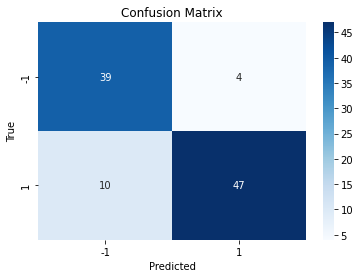

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Kernelized Perceptron Class
class KernelPerceptron:
    def __init__(self, lr=0.01, max_epochs=1000, kernel='linear', degree=2, gamma=None):
        self.lr = lr
        self.max_epochs = max_epochs
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.alpha = None
        self.bias = 0

    def _kernel_matrix(self, X):
        """Compute the kernel matrix for all pairwise operations."""
        if self.kernel == 'poly':
            return (np.dot(X, X.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1 / X.shape[1]
            X_norm = np.sum(X ** 2, axis=1)
            return np.exp(-self.gamma * (X_norm[:, None] + X_norm[None, :] - 2 * np.dot(X, X.T)))
        else:
            return np.dot(X, X.T)

    def _kernel_matrix_predict(self, X_test, X_train):
        """Compute the kernel matrix for prediction (test vs. train)."""
        if self.kernel == 'poly':
            return (np.dot(X_test, X_train.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1 / X_train.shape[1]
            X_test_norm = np.sum(X_test ** 2, axis=1)
            X_train_norm = np.sum(X_train ** 2, axis=1)
            return np.exp(
                -self.gamma * (X_test_norm[:, None] + X_train_norm[None, :] - 2 * np.dot(X_test, X_train.T))
            )
        else:
            return np.dot(X_test, X_train.T)

    def train(self, X, y, tolerance=5):
        """Train the perceptron with a mechanism to detect non-convergence."""
        self.X_train = X  # Store training data
        self.y_train = y  # Store training labels

        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)
        self.bias = 0

        # Compute the kernel matrix
        kernel_matrix = self._kernel_matrix(X)
        accuracy_history = []

        no_update_epochs = 0  # Counter for epochs with no updates

        for epoch in range(self.max_epochs):
            incorrect = 0
            updates = 0  # Track updates in the current epoch

            for i in range(n_samples):
                prediction = np.sign(np.sum(self.alpha * y * kernel_matrix[i]) + self.bias)
                if prediction != y[i]:
                    self.alpha[i] += self.lr
                    self.bias += self.lr * y[i]
                    incorrect += 1
                    updates += 1  # Track updates

            epoch_accuracy = 1 - (incorrect / n_samples)
            accuracy_history.append(epoch_accuracy)

            # If no updates in this epoch, increment no_update_epochs
            if updates == 0:
                no_update_epochs += 1
            else:
                no_update_epochs = 0  # Reset counter if updates occurred

            # Stop training if no updates for 'tolerance' consecutive epochs
            if no_update_epochs >= tolerance:
                print(f"Training stopped at epoch {epoch + 1} due to non-convergence.")
                break

            # Early stopping if accuracy converges
            if epoch > 2 and accuracy_history[-1] == accuracy_history[-2] == accuracy_history[-3]:
                print(f"Training stopped at epoch {epoch + 1} due to convergence.")
                break

        return accuracy_history

    def predict(self, X_test):
        """Predict labels for given test data using the trained model."""
        kernel_matrix = self._kernel_matrix_predict(X_test, self.X_train)
        predictions = np.sign(np.dot(self.alpha * self.y_train, kernel_matrix.T) + self.bias)
        return predictions

# Evaluate Model
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["-1", "1"], yticklabels=["-1", "1"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Main script
if __name__ == "__main__":
    # Generate XOR dataset (non-linearly separable)
    X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
    y = np.where(y == 0, -1, 1)  # Convert labels to -1 and 1

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the perceptron
    perceptron = KernelPerceptron(lr=0.01, max_epochs=1000, kernel='linear')
    accuracy_history = perceptron.train(X_train, y_train, tolerance=5)

    # Test and evaluate
    y_pred = perceptron.predict(X_test)
    evaluate_model(y_test, y_pred)
